## A First Organic Agent in RecoGym

This far in the course you have used standard datasets in order to model user preferences.  These datasets contained information about user preferences, but they were not logs of an actual recommender system.

In this part of the course we will move beyond what is possible using standard datasets of user preferences and we will simulate a recommender system using the RecoGym environment.

As a first exercise we will consider how to build a first recommender systems using embeddings like the ones we previously computed (in this case we will use SVD embeddings).


A recommender system is typically built up from components.

1. a) We observe behaviour from the user unrelated to the recommender system.  We use this information to produce a user representation, for example we can use feature engineering to turn their history into a fixed length user vector.

1. b) It is often the case that in this part of the model we will build a model of the next item that the user will view - this can help "seed" recommendation models.

2. We observe logs of the recommender system in action.  For example we observe the recommender system delivering recommendations and the user either clicking or not clicking on them.

Most of the work considered so far has been on 1 a) and 1 b).  In this notebook we will complete this part of the journey i.e. 1 a) and 1 b) we will use the RecoGym environment to build SVD embeddings of users, we will then use an organic next item prediction as a recommendation.  In this notebook we will not use logs of the recommender system for refining the recommender system, but we will use simulated recommender system logs to evaluate the performance.
We will start by focusing on a classical offline evaluation setting, where we try to predict the user's next organic view and measure precision/recall/hit-rate@k on a logged dataset.
Then, we will make on offline estimation of the Click-Through Rate (CTR) different models might attain, using the Inverse Propensity Score (IPS) to provide an unbiased estimate.
As the usefulness of IPS estimators is highly dependent on the overlap between logging and treatment policies, we will show the impact of this as well.
Finally, we simulate an actual A/B-test, measuring CTR for every agent.

Actually training on the recommender system logs (also known as bandit feedback) i.e. component 2) is the subject of the next notebook.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numpy.random.mtrand import RandomState
from reco_gym import Configuration
from agents import Agent
from scipy.special import logsumexp
import pandas as pd
from scipy.stats.distributions import beta
from copy import deepcopy
from agents import OrganicUserEventCounterAgent, organic_user_count_args

from reco_gym.envs.observation import Observation
from agents import RandomAgent, random_args
from reco_gym import verify_agents, verify_agents_IPS
from reco_gym.evaluate_agent import plot_verify_agents, verify_agents_recall_at_k

import pylab


# from Keras
def to_categorical(y, num_classes=None, dtype='float32'):
  y = np.array(y, dtype='int')
  input_shape = y.shape
  if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
    input_shape = tuple(input_shape[:-1])
  y = y.ravel()
  if not num_classes:
    num_classes = np.max(y) + 1
  n = y.shape[0]
  categorical = np.zeros((n, num_classes), dtype=dtype)
  categorical[np.arange(n), y] = 1
  output_shape = input_shape + (num_classes,)
  categorical = np.reshape(categorical, output_shape)
  return categorical


import gym, reco_gym
import numpy as np
# env_0_args is a dictionary of default parameters (i.e. number of products)
from reco_gym import env_1_args, Configuration

# Set style for pretty plots
plt.style.use('ggplot')

P = 500  # Number of Products
U = 5000 # Number of Users

# You can overwrite environment arguments here:
env_1_args['random_seed'] = 42
env_1_args['num_products']= P
env_1_args['phi_var']=0.0
env_1_args['number_of_flips']=P//2
env_1_args['sigma_mu_organic'] = 0.0
env_1_args['sigma_omega']=0
# Initialize the gym for the first time by calling .make() and .init_gym()
env = gym.make('reco-gym-v1')
env.init_gym(env_1_args)

env.reset()

In [2]:
# Set fixed figure size for plots
pylab.rcParams['figure.figsize'] = 7, 7

In [3]:
# Generate RecSys logs for U users
reco_log = env.generate_logs(U)
reco_log.head(20)

,a,c,ps,ps-a,t,u,v,z
0,NaN,NaN,NaN,None,0,0,87.0,organic
1,NaN,NaN,NaN,None,1,0,140.0,organic
2,NaN,NaN,NaN,None,2,0,288.0,organic
3,NaN,NaN,NaN,None,3,0,56.0,organic
4,NaN,NaN,NaN,None,4,0,260.0,organic
5,NaN,NaN,NaN,None,5,0,395.0,organic
6,NaN,NaN,NaN,None,6,0,31.0,organic
7,343.0,0.0,0.002,"[0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.0...",7,0,NaN,bandit
8,62.0,0.0,0.002,"[0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.0...",8,0,NaN,bandit
9,162.0,0.0,0.002,"[0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.0...",9,0,NaN,bandit


In [4]:
# Filter out only organic views
organic_reco_log = reco_log[reco_log['z']=='organic']

# Build a user-item matrix filled with counts
counts = np.zeros((U,P))
for u in range(U):
    counts[u,:] = to_categorical(np.array(organic_reco_log[organic_reco_log['u']==u].v,dtype=int),P).sum(0)

# counts ignores time, but otherwise produces a representation of the users interests    
# you can either factorize counts directly or instead look at the co_counts i.e.
counts[0,:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [5]:
# Binarise counts 
counts_above_zero = 1.*(counts>0) # above zero counts only

co_counts = np.matmul(counts_above_zero.T,counts_above_zero)

In [6]:
# a product might be summarised by the P length vector of its co-counts, e.g. for product 0
co_counts[0,:]

array([89.,  3.,  1.,  2.,  3.,  4.,  1.,  1.,  4.,  9.,  3.,  1.,  2.,
        6., 24., 10.,  4.,  3.,  0.,  2.,  1.,  2., 22.,  4.,  8.,  7.,
        6.,  7.,  3.,  5.,  1.,  2.,  2.,  9.,  1.,  7.,  3.,  3.,  0.,
        8., 12.,  5.,  5.,  0.,  8.,  0.,  1.,  2.,  9.,  7., 20.,  3.,
        3.,  0.,  6.,  3.,  3.,  3.,  1.,  4.,  1.,  0.,  4.,  1., 18.,
        3.,  0.,  4.,  3.,  1.,  3.,  2.,  2.,  2.,  7., 12.,  1.,  9.,
       11.,  6.,  1.,  1., 10.,  5.,  7., 19., 10.,  0.,  6.,  4.,  2.,
        2.,  4.,  0., 13., 25.,  4.,  9.,  0.,  4.,  7.,  2.,  0.,  1.,
        4.,  6.,  4.,  0., 23.,  2.,  3.,  1.,  3.,  3.,  2.,  0., 16.,
        4.,  2.,  1., 10.,  5.,  2.,  8., 13.,  2.,  4.,  1.,  3.,  5.,
        3.,  0.,  3.,  1.,  7.,  7.,  7.,  3.,  2.,  3.,  1.,  0.,  1.,
        0.,  6.,  2.,  4., 10.,  6.,  3.,  7.,  4.,  4.,  3.,  7.,  3.,
        4.,  7.,  1.,  2.,  4., 10.,  5.,  2., 10.,  3.,  1.,  7.,  4.,
        9.,  8.,  2., 17.,  4.,  2.,  2., 15.,  5.,  9.,  4.,  6

This methodology works, but it doesn't scale.  At Criteo we have one billion products; try re-running the above with just a few 1000 users and products, the user vectors become long and sparse and the co-counts matrix is also very sparse.  We can determine similarities only between the most popular products.  In order to make the product embeddings both much shorter than P and not sparse we can use matrix factorization models.  You can either factorize the count matrix above or the co_counts matrix.

In [7]:
# Compute eigen-values and vectors, sort eigen-values in descending order
w,v = np.linalg.eig(co_counts)
idx = np.argsort(w)[::-1] 
v=np.real(v[:,idx])
w=np.real(w[idx])

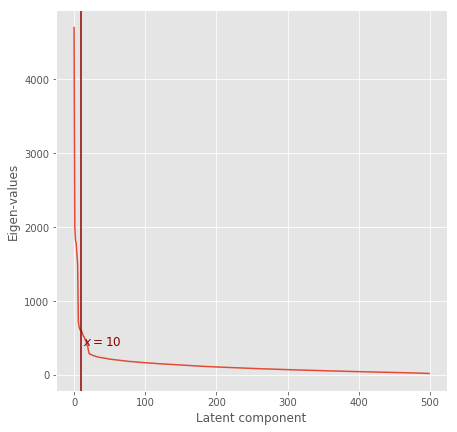

In [8]:
# Plot eigen-values for every latent component too see the added value for every component
fig, ax = plt.subplots()
plt.plot(w)
plt.axvline(10, color= 'darkred')
plt.text(12, 400 , '$x = 10$', fontsize = 12, color = 'darkred')
plt.xlabel('Latent component')
plt.ylabel('Eigen-values')
plt.show()

The plot above shows the eigen-values for every latent component in the co-counts matrix.
We can see a steep drop after the 7th component, indicating that the first 7 are vital for reconstructing the original matrix, but the gains from adding additional components are only marginal.
In what follows, we show that the resulting eigendecomposition is successful in reconstructing the original matrix.

In [9]:
# Keep the first n_factors eigen-values and vectors, decompose the matrix
wdash = np.zeros_like(w)
n_factors = 10
wdash[0:n_factors] = w[0:n_factors]
embeddings = np.matmul(v,np.sqrt(np.diag(wdash)))[:,0:n_factors] # Only keep non-zero components

In [10]:
# Re-scale for contrast, compute range for colormap
root=12
vvmax = ((np.matmul(embeddings,embeddings.T))).max()**(1/root)

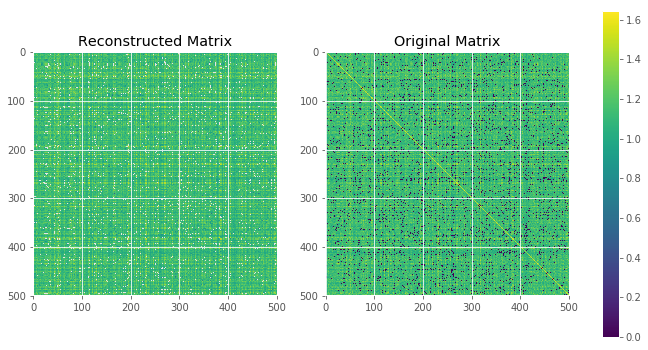

In [11]:
# Plot both matrices next to each other
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (12,6))
axes[0].set_title('Reconstructed Matrix')
axes[0].imshow((np.matmul(embeddings,embeddings.T))**(1/root),vmin=0,vmax=vvmax)
axes[1].set_title('Original Matrix')
tmp = axes[1].imshow((co_counts)**(1/root),vmin=0,vmax=vvmax)
fig.colorbar(tmp, ax = axes)
plt.show()

The figure above shows the eigen-value decomposition (_left_) and the original co-count matrix (_right_).
We can see that the reconstructed matrix is clearly able to approximate the structure of the original matrix.
Furthermore, zero-values in the original matrix are often filled in for the eigen-value decomposition.
The reason for this, is that due to being a low-rank approximation, it is able to exploit transitivity between items.
For example, if product 0 has a high co-count with product 1, and product 1 has a high co-count with product 2; the approximation will infer that there exists a positive relation between products 0 and 2 as well.

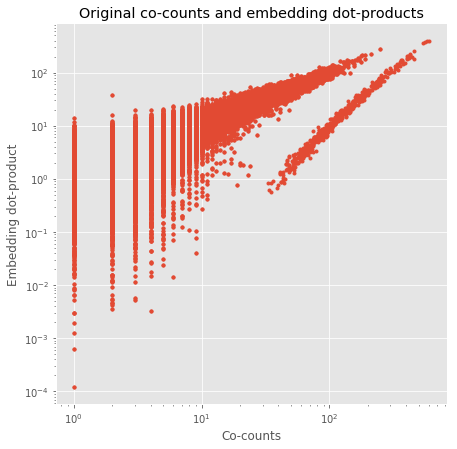

In [12]:
_, ax = plt.subplots()
plt.title('Original co-counts and embedding dot-products')
plt.plot(co_counts.flatten(),(np.matmul(embeddings,embeddings.T)).flatten(),'.')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Co-counts')
plt.ylabel('Embedding dot-product')
plt.show()

Here, we plot the original co-counts (_x-axis_) and the dot-product of the resulting embeddings (_y-axis_).
We can see there exists a clear positive relation: the decomposition is able to retrieve the positive signals that were present in the original data.
Furthermore, the low-rank approximation infers transitive relations that were not clear from the original matrix.

## An organic SVD agent

Below we have an organic SVD agent.  This agent is trained on an offline log of organic user events in the same way as above - we place this code in the `create_embeddings` function.  We then define the AgentFromLog class which takes an organic reco log and produces the embedding.  It then is deployed in a real system.  When an agent receives events we create a user embedding by averaging the product embedding of all the items the user saw.  When the agent is called upon to act (the `act` method) it computes a dot product of each product embedding with the product embedding corresponding to each possible recommendation with high probability.
The highest of these is selected.

In [13]:
def create_embeddings(reco_log, U, P, K = 5):
    organic_reco_log = reco_log[reco_log['z']=='organic']
    counts = np.zeros((U,P))

    for u in range(U):
        counts[u,:] = to_categorical(np.array(organic_reco_log[organic_reco_log['u']==u].v,dtype=int),P).sum(0)

    counts_above_zero = 1.*(counts>0) # above zero counts only
    co_counts = np.matmul(counts_above_zero.T,counts_above_zero)
    
    w , v = np.linalg.eig(co_counts)
    idx = np.argsort(w)[::-1] 
    v = np.real(v[:,idx])
    w = np.real(w[idx])

    wdash = np.zeros_like(w)

    wdash[0:K] = w[0:K]
    embeddings = np.matmul(v,np.sqrt(np.diag(wdash)))[:,0:K] # keep the non-zero components
    return embeddings

class AgentFromLog(Agent):
    def __init__(self, config, reco_log, U = U, P = P, K = 5, greedy = False):
        super(AgentFromLog, self).__init__(config)
        self.rng = RandomState(self.config.random_seed)
        self.organic_views = np.zeros(self.config.num_products)
        assert(P >= K)
        assert(reco_log.v.max() < P)
        self.embeddings = create_embeddings(reco_log, U, P, K)
        self.K = K
        self.history_length = 0
        self.greedy = greedy
        
    def observe(self, observation):
        for session in observation.sessions():
            self.user_embedding += self.embeddings[session['v'],:]
            self.history_length += 1

    def act(self, observation, reward, done):
        """Act method returns an Action based on current observation and past history"""
        self.observe(observation)
        uprob = np.matmul(self.embeddings,self.user_embedding/self.history_length)
        if self.greedy:
            uprob *= 10 # Make it greedy by spreading out values before the softmax
        prob = np.exp(uprob-logsumexp(uprob))
        # Sample action according to probability distribution
        action = self.rng.choice(self.config.num_products, p = prob)
        return {
            **super().act(observation, reward, done),
            **{
                'a': action,
                'ps': prob[action],
                'ps-a': prob,
            },
        }

    def reset(self):
        self.user_embedding = np.zeros(self.K)
        self.history_length = 0

We generate several of the above agents, for a varying number of latent components.
Furthermore, we generate an agent that simply counts the number of organic views for every product, and recommends the most viewed product.
This can be seen as a popularity baseline.
Finally, we add a random agent, which will generate recommendations uniformly-at-random.

In [14]:
embedding_agent5  = AgentFromLog(Configuration(env_1_args), reco_log, U, P, 5, True)
embedding_agent20 = AgentFromLog(Configuration(env_1_args), reco_log, U, P, 20, True)
embedding_agent50 = AgentFromLog(Configuration(env_1_args), reco_log, U, P, 50, True)
embedding_agent100 = AgentFromLog(Configuration(env_1_args), reco_log, U, P, 100, True)

organic_counter_agent = OrganicUserEventCounterAgent(Configuration({
            **organic_user_count_args,
            **env_1_args,
            'select_randomly': True,
        }))

random_args['num_products'] = P
agent_rand = RandomAgent(Configuration({**env_1_args, **random_args,}))

# Offline Evaluation
All of the above is quite recognisable from earlier parts of the course, but now here things differ.
We will use the logged feedback we obtained from the recommender system to evaluate the agents we defined earlier.

In [15]:
# Placeholder for agents
agents = {
    'SVD-5': embedding_agent5,
    'SVD-20': embedding_agent20,
    'SVD-50': embedding_agent50, 
    'SVD-100': embedding_agent100,
    'Popularity': organic_counter_agent,
    'Random': agent_rand
}

# Generate new logs, to be used for offline testing
test_log = env.generate_logs(U)

## Traditional Evaluation on Organic Feedback
First, we will focus on a classical offline evaluation setting, where we try to predict the user's next organic view and measure precision/recall/hit-rate@k on a logged dataset.

In [16]:
# Evaluate
result_recall = verify_agents_recall_at_k(test_log, deepcopy(agents), k = 5)
result_recall

,0.025,0.500,0.975,Agent
0,0.229153,0.235273,0.241392,SVD-5
1,0.261977,0.268370,0.274763,SVD-20
2,0.251030,0.257338,0.263645,SVD-50
3,0.244423,0.250677,0.256930,SVD-100
4,0.223893,0.229965,0.236036,Popularity
5,0.006776,0.008066,0.009357,Random


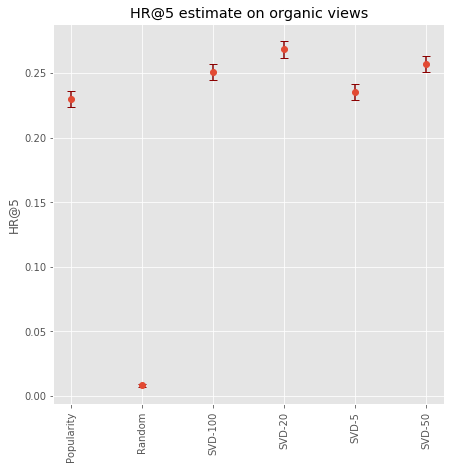

In [17]:
# Plot results
fig = plot_verify_agents(result_recall)
plt.title('HR@5 estimate on organic views')
plt.ylabel('HR@5')
plt.show()

The plots shows the Hit-Rate@5 that different models attain on the test set, where blue dots represent the mean and the red bars represent the standard error.
As a general trend, we see that the performance of the embedding-based agents improves when more latent factors are used, as is expected.
Furthermore, the organic popularity-based model seems to be a fair contender, yet not entirely on the same level as the best embedding-based agent.
The random policy performs poorly, as is to be expected as well.

These results, however, paint a very optimistic image.
Purely going from the above results, we would conclude that an SVD-based model using 100 latent factors will, in more than 25% of the cases be able to predict the user's next organic view in a list of 5 options.

## Unbiased Evaluation from Bandit Feedback

Note that until now, we haven't used _any_ of the information that we have obtained through the live recommender system.
All embedding-based agents are trained purely on co-counts of organic views, and so is the popularity baseline.

Nevertheless, on top of these organic views, we have access to so-called bandit feedback as well.
These are actual actions taken by the recommender system: products that were shown to the user, along with a logged response from said user (_click_ or _no-click_).
We can use these logs to estimate how well a new model would have performed, if that would have been the model showing recommendations to the user.

In order to do this we use what is known as an Inverse Propensity Score (IPS) estimator.
The basis of this idea is that we have an offline log of a randomised policy (i.e. a policy that uses some level of randomness to choose actions, although it typically chooses good actions).
We will refer to this as the _logging policy_, $\pi_l$.

Now, we develop a new treatment policy, $\pi_t$.
The logged probability of past actions is used to adjust the new policy so that if $\pi_t$ deploys an action more often, we increase the weighting of that component.
If $\pi_t$ deploys an action less often, we downweight the expected number of clicks as attributed to that action.

If we have a set of action ($a$), context ($x$), reward ($c$) -tuples $\mathcal{L} = \{(a, x ,c)\}$, we can estimate the Click-Through Rate (CTR) for the new policy $\pi_t$ by the following equation:

$$\text{CTR}_{\pi_t}(\mathcal{L}) = \frac{1}{|\mathcal{L}|}\sum_{(a,x,c) \in \mathcal {L}} c \frac{\pi_t(a|x)}{\pi_l(a|x)}$$

In [18]:
# Evaluate
agent_copy = deepcopy(agents)
result_IPS = verify_agents_IPS(test_log, agent_copy)
result_IPS

,0.025,0.500,0.975,Agent
0,0.006353,0.014942,0.023531,SVD-5
1,0.007176,0.016114,0.025053,SVD-20
2,0.006285,0.014871,0.023456,SVD-50
3,0.006863,0.015496,0.024130,SVD-100
4,0.010187,0.014045,0.017902,Popularity
5,0.009797,0.010112,0.010427,Random


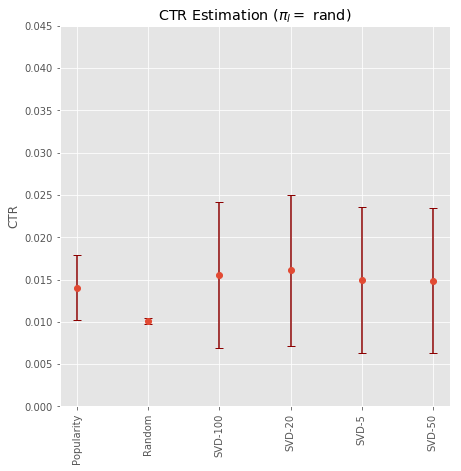

In [19]:
fig = plot_verify_agents(result_IPS)
plt.ylim((.0,.045))
plt.title('CTR Estimation ($\pi_l = $ rand)')
plt.ylabel('CTR')
plt.show()

A first thing to note, is the scale of the y-axis compared to the previous evaluation procedure.
Whereas our accuracy estimate for predicting the user's next action in a top-k fashion was around ~25%, we see here that CTR estimates lay in the range of 1-3%.
Although this provides a much less optimistic view of model performance, these absolute values already much closer align to what you would expect to see in a real-world system.

Secondly, it is nearly impossible to draw conclusions from this plot, due to the high variance of the estimates.
This variance is dependent on the ratio $\frac{\pi_t(a|x)}{\pi_l(a|x)}$, i.e. how different the logging and treatment policies actually are.
As such, it makes sense that for radically different $\pi_t$ and $\pi_l$, we will see high variance.

The logging policy, in this case, was uniformly random.
This means that every time a recommendation was shown to the user, this could have been any product with the same probability, i.e. $\pi_l(a|x) = \frac{1}{|P|}$.

As (most of) the other agents we are evaluating are actually trying to personalise and pick the best possible action for the given user and context, their probability distribution over the possible actions will be very different.
This causes the variance to go through the roof, and leaves us with an unbiased yet unuseful measurement.

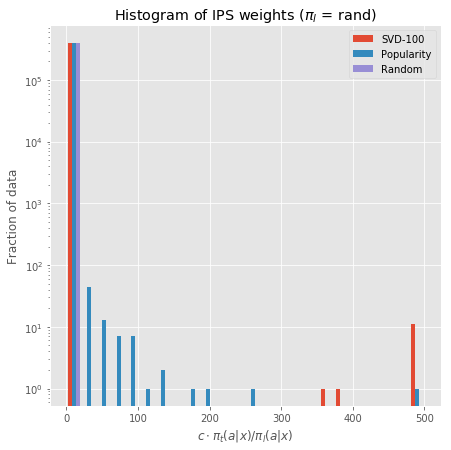

In [20]:
from reco_gym.evaluate_agent import evaluate_IPS
fig, axes = plt.subplots()
plt.hist([evaluate_IPS(agent_copy[agent_id], test_log) for agent_id in ['SVD-100','Popularity','Random']],
         bins = 24,
         density = False,
         log = True,
         label = ['SVD-100','Popularity','Random'])
plt.title('Histogram of IPS weights ($\pi_l$ = rand)')
plt.xlabel('$c\cdot\pi_t(a|x)/\pi_l(a|x)$')
plt.ylabel('Fraction of data')
plt.legend()
plt.show()

### IPS - Influence of the Logging Policy (Popularity)

In a real-world system, the logging policy will most often be an earlier version of some agent, instead of a fully randomised one.
As a consequence, the differences between $\pi_l$ and $\pi_t$ will often only be marginal, and the variance will be much more controlled and acceptable.

Here, we re-run the previous experiment on a simulated test set with a different logging policy: the organic counter.

In [21]:
# Generate second test log, with Organic-counter as logging policy
test_log2 = env.generate_logs(U, agent = deepcopy(organic_counter_agent))

In [22]:
# Evaluate
agent_copy = deepcopy(agents)
result_IPS2 = verify_agents_IPS(test_log2, agent_copy)
result_IPS2

,0.025,0.500,0.975,Agent
0,0.009921,0.011060,0.012199,SVD-5
1,0.013891,0.015004,0.016117,SVD-20
2,0.015150,0.016271,0.017392,SVD-50
3,0.016401,0.017559,0.018717,SVD-100
4,0.015324,0.015724,0.016124,Popularity
5,0.000410,0.000427,0.000443,Random


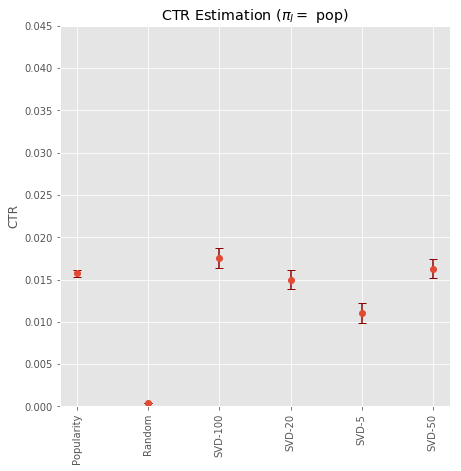

In [23]:
fig = plot_verify_agents(result_IPS2)
plt.ylim((.0,.045))
plt.title('CTR Estimation ($\pi_l = $ pop)')
plt.ylabel('CTR')
plt.show()

Although the estimates broadly correspond to the same range of values, we can see that the confidence intervals are much tighter than before.
This reduced variance is a consequence of the fact that the target and logging policies are much more aligned.

In [ ]:
fig, axes = plt.subplots()
plt.hist([evaluate_IPS(agent_copy[agent_id], test_log2) for agent_id in ['SVD-100','Popularity','Random']],
         bins = 24,
         density = False,
         log = True,
         label = ['SVD-100','Popularity','Random'])
plt.title('Histogram of IPS weights ($\pi_l$ = pop)')
plt.xlabel('$c\cdot\pi_t(a|x)/\pi_l(a|x)$')
plt.ylabel('Fraction of data')
plt.legend()
plt.show()

## A/B-Tests

IPS, while powerful, is often too noisy to rank agent performance.
As we showed in the previous experiments, this is especially the case if the serendipitous agreement between the old and the new policy is rare.
When that is the case, the variance will often be too high to draw unambiguous conclusions from the experimental results.

There may be no alternative than to actually deploy an algorithm in production, i.e. run an A/B-test.
This is usually done subject to reasonable offline metrics, as it is costly and time consuming to perform.

In [ ]:
result_AB = verify_agents(env, U, deepcopy(agents))
result_AB

In [ ]:
fig = plot_verify_agents(result_AB)
#plt.ylim((.0,.045))
plt.ylabel('CTR')
plt.show()

The above plot shows results of a simulated A/B-test, with the same set of agents that we've been using before.
These results can be seen as a ground truth measurement of actual online model performance, which is what we have been trying to approximate with the previous evaluation methods.

For the SVD-based models, we see a general trend of improved performance when using more latent factors.
However, as expected, we also observe diminishing returns.

Furthermore, the best embedding-based agent outperforms the popularity baseline, with statistical significance.
Nevertheless, the effect size is rather small.
This is a common result when A/B-testing alternative models: it is often hard to draw conclusions, and improvements will often be incremental in nature.

One final interesting thing to note, is that the random policy achieves a CTR of around 1%.
Almost all offline measures, however, severely underestimated its performance.
What we see here, is a side-effect of IPS.
As the serendipitous agreement between the more advanced models and the random policy is rare, the sample size for the evaluation is effectively too low to draw unambiguous conclusions.

In later parts of the course, we will discuss the limitations of the naive IPS estimation, and ways to mitigate its well-known issues.